In [1]:
import logging
import os
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import wandb
from model import UNet, UNetWithGradCAM
from utils.data_loading import BuildingsDataset

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load and preprocess the test dataset
DATA_DIR = "../data/"
x_test_dir = os.path.join(DATA_DIR, "test/")

test_dataset = BuildingsDataset(x_test_dir)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model = UNetWithGradCAM(UNet(5, 3))
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [53]:
def convert_output_to_prediction(output_mask: np.ndarray):
    new_arr = np.zeros_like(output_mask)
    max_indices = np.argmax(output_mask, axis=2)
    new_arr[
        np.arange(output_mask.shape[0])[:, None],
        np.arange(output_mask.shape[1]),
        max_indices,
    ] = 1
    return new_arr

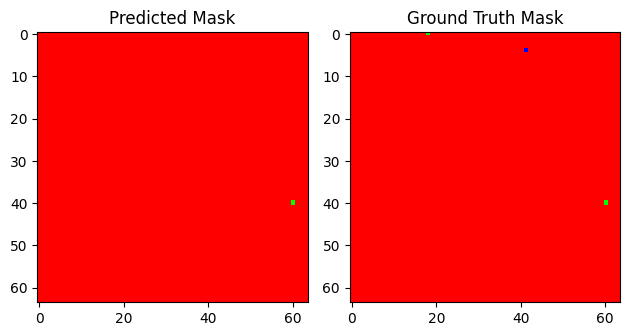

In [56]:
image, gt_mask = test_dataset[238]
x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
x_tensor = x_tensor.permute(0, 3, 1, 2).float().to(device)
# Predict test image
pred_mask = model(x_tensor)
tensor_to_detach = pred_mask[
    0
]  # Assuming the tensor you want to detach is the first element of the tuple
pred_mask_array = tensor_to_detach.detach().squeeze().cpu().numpy()
pred_mask = np.transpose(pred_mask_array, (1, 2, 0))
pred_mask_converted = convert_output_to_prediction(pred_mask)


# Plotting predicted mask
plt.subplot(1, 2, 1)
plt.imshow(pred_mask_converted)
plt.title("Predicted Mask")

# Plotting ground truth mask
plt.subplot(1, 2, 2)
plt.imshow(gt_mask)
plt.title("Ground Truth Mask")

# Adjusting subplot layout and displaying the plot
plt.tight_layout()
plt.show()